# Comprehensive Time Series EDA - VN2 Competition

**Parallel Processing on Apple M2 Max (12 cores, 64GB RAM)**

This notebook performs deep exploratory data analysis on ~3 years of weekly sales data:
- Summary statistics & dispersion coefficients
- Stationarity & heteroskedasticity tests (ADF, KPSS, ARCH)
- ACF/PACF analysis
- Lag analysis & lead-lag relationships
- Frequency domain analysis (periodograms)
- Master SLURP construction with metadata preservation
- Bootstrap analysis leveraging relationship preservation

**Optimization**: All analyses parallelized across 11 workers, memory-optimized data structures.


In [17]:
# Setup: Environment & Imports
import os
os.environ['OMP_NUM_THREADS'] = '12'
os.environ['MKL_NUM_THREADS'] = '12'
os.environ['OPENBLAS_NUM_THREADS'] = '12'

import sys
sys.path.insert(0, '../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import warnings
import time
from contextlib import contextmanager

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

N_JOBS = 11  # Leave 1 core for system
print(f"🚀 Using {N_JOBS} parallel workers on {cpu_count()} cores")
print(f"📊 NumPy using {np.show_config()}")

@contextmanager
def timer(name):
    start = time.perf_counter()
    yield
    elapsed = time.perf_counter() - start
    print(f"⏱️  {name}: {elapsed:.2f}s")


🚀 Using 11 parallel workers on 12 cores
Build Dependencies:
  blas:
    detection method: system
    found: true
    include directory: unknown
    lib directory: unknown
    name: accelerate
    openblas configuration: unknown
    pc file directory: unknown
    version: unknown
  lapack:
    detection method: system
    found: true
    include directory: unknown
    lib directory: unknown
    name: accelerate
    openblas configuration: unknown
    pc file directory: unknown
    version: unknown
Compilers:
  c:
    commands: cc
    linker: ld64
    name: clang
    version: 15.0.0
  c++:
    commands: c++
    linker: ld64
    name: clang
    version: 15.0.0
  cython:
    commands: cython
    linker: cython
    name: cython
    version: 3.1.3
Machine Information:
  build:
    cpu: aarch64
    endian: little
    family: aarch64
    system: darwin
  host:
    cpu: aarch64
    endian: little
    family: aarch64
    system: darwin
Python Information:
  path: /private/var/folders/y6/nj790rtn

## 1. Load & Prepare Data

Load all raw files and reshape to long format for analysis.


In [18]:
with timer("Data loading"):
    # Load raw files
    sales = pd.read_csv('../data/raw/Week 0 - 2024-04-08 - Sales.csv')
    stock = pd.read_csv('../data/raw/Week 0 - In Stock.csv')
    master = pd.read_csv('../data/raw/Week 0 - Master.csv')
    
    # Melt to long format
    sales_long = sales.melt(
        id_vars=['Store', 'Product'], 
        var_name='week', 
        value_name='sales'
    )
    sales_long['week_date'] = pd.to_datetime(sales_long['week'])
    sales_long['year'] = sales_long['week_date'].dt.year
    sales_long['retail_week'] = sales_long['week_date'].dt.isocalendar().week
    sales_long['month'] = sales_long['week_date'].dt.month
    
    stock_long = stock.melt(
        id_vars=['Store', 'Product'], 
        var_name='week', 
        value_name='in_stock'
    )
    
    # Merge
    df = sales_long.merge(
        stock_long, 
        on=['Store', 'Product', 'week']
    ).merge(
        master,
        on=['Store', 'Product']
    ).sort_values(['Store', 'Product', 'week']).reset_index(drop=True)

# Memory optimization
df_optimized = df.copy()
df_optimized['Store'] = df_optimized['Store'].astype('int16')
df_optimized['Product'] = df_optimized['Product'].astype('int16')
df_optimized['sales'] = df_optimized['sales'].astype('float32')
df_optimized['year'] = df_optimized['year'].astype('int16')
df_optimized['retail_week'] = df_optimized['retail_week'].astype('int8')
df_optimized['month'] = df_optimized['month'].astype('int8')
df_optimized['in_stock'] = df_optimized['in_stock'].astype('bool')

for col in ['ProductGroup', 'Division', 'Department', 'DepartmentGroup', 'StoreFormat', 'Format']:
    if col in df_optimized.columns:
        df_optimized[col] = df_optimized[col].astype('category')

mem_before = df.memory_usage(deep=True).sum() / 1024**2
mem_after = df_optimized.memory_usage(deep=True).sum() / 1024**2

df = df_optimized  # Use optimized version

print(f"\n📦 Data shape: {df.shape}")
print(f"📅 Date range: {df['week_date'].min()} to {df['week_date'].max()}")
print(f"🏪 Stores: {df['Store'].nunique()}, Products: {df['Product'].nunique()}")
print(f"💾 Memory: {mem_before:.1f} MB → {mem_after:.1f} MB ({(1-mem_after/mem_before)*100:.1f}% reduction)")
print(f"\n✅ All data loaded and in memory")


⏱️  Data loading: 0.07s

📦 Data shape: (94043, 15)
📅 Date range: 2021-04-12 00:00:00 to 2024-04-08 00:00:00
🏪 Stores: 67, Products: 297
💾 Memory: 13.7 MB → 7.7 MB (43.7% reduction)

✅ All data loaded and in memory


## 2. Master SLURP Construction

Create one grand SLURP where each row = one SKU-week observation with all metadata preserved for bootstrap analysis.


In [19]:
from vn2.uncertainty import SLURP

with timer("SLURP construction"):
    # Create scenario ID
    df['scenario_id'] = df.index
    
    # Build SIP dictionary with all variables
    sip_dict = {
        'sales': df['sales'].values,
        'store': df['Store'].values,
        'product': df['Product'].values,
        'retail_week': df['retail_week'].values,
        'year': df['year'].values,
        'month': df['month'].values,
        'in_stock': df['in_stock'].astype(int).values,  # 1/0 for True/False
        'product_group': df['ProductGroup'].cat.codes.values,
        'department': df['Department'].cat.codes.values,
        'store_format': df['StoreFormat'].cat.codes.values,
    }
    
    # Metadata
    meta_df = pd.DataFrame({
        'field_type': ['continuous', 'discrete', 'discrete', 'discrete', 'discrete', 'discrete',
                       'binary', 'discrete', 'discrete', 'discrete'],
        'description': ['Weekly sales', 'Store ID', 'Product ID', 'ISO week', 'Year', 'Month',
                        'Stock availability', 'Product group', 'Department', 'Store format']
    }, index=list(sip_dict.keys())).T
    
    # Create master SLURP
    master_slurp = SLURP.from_dict(
        sip_dict, 
        meta=meta_df,
        provenance="VN2 Historical Demand 2021-2024 with Metadata"
    )
    
    # Save
    master_slurp.to_xml('../data/processed/master_demand_slurp.xml', csvr=4, average=True, median=True)
    df.to_parquet('../data/processed/demand_long.parquet')

print(f"✅ SLURP created: {master_slurp.n_scenarios:,} scenarios")
print(f"   Variables: {list(master_slurp.names)}")
print(f"   Saved to: ../data/processed/master_demand_slurp.xml")


⏱️  SLURP construction: 0.36s
✅ SLURP created: 94,043 scenarios
   Variables: ['sales', 'store', 'product', 'retail_week', 'year', 'month', 'in_stock', 'product_group', 'department', 'store_format']
   Saved to: ../data/processed/master_demand_slurp.xml


## 3. Summary Statistics & Dispersion (Parallel)

Compute comprehensive statistics for all 599 SKUs in parallel.


In [20]:
from scipy.stats import skew, kurtosis

def compute_sku_summary(key_and_data):
    """Compute all summary stats for one SKU"""
    (store, product), sku_data = key_and_data
    sales = sku_data['sales'].values
    non_zero = sales[sales > 0]
    
    return {
        'Store': store,
        'Product': product,
        'n_weeks': len(sales),
        'mean': sales.mean(),
        'std': sales.std(),
        'min': sales.min(),
        'q25': np.percentile(sales, 25),
        'median': np.median(sales),
        'q75': np.percentile(sales, 75),
        'max': sales.max(),
        'cv': sales.std() / (sales.mean() + 1e-9),
        'qcd': (np.percentile(sales, 75) - np.percentile(sales, 25)) / 
               (np.percentile(sales, 75) + np.percentile(sales, 25) + 1e-9),
        'mad': np.median(np.abs(sales - np.median(sales))),
        'mad_mean_ratio': np.median(np.abs(sales - np.median(sales))) / (sales.mean() + 1e-9),
        'iqr': np.percentile(sales, 75) - np.percentile(sales, 25),
        'range': sales.max() - sales.min(),
        'skewness': skew(sales),
        'kurtosis': kurtosis(sales),
        'pct_zeros': (sales == 0).mean(),
        'pct_stockout': (~sku_data['in_stock']).mean(),
        'adi': len(sales) / len(non_zero) if len(non_zero) > 0 else np.inf,
    }

with timer("Summary statistics (parallel)"):
    sku_groups = list(df.groupby(['Store', 'Product']))
    summary_list = Parallel(n_jobs=N_JOBS, verbose=1)(
        delayed(compute_sku_summary)(item) for item in sku_groups
    )
    summary = pd.DataFrame(summary_list)
    summary.to_parquet('../data/processed/summary_statistics.parquet')

print(f"\n✅ Summary stats computed for {len(summary)} SKUs")
print(f"\nOverall statistics:")
print(summary[['mean', 'std', 'cv', 'skewness', 'pct_zeros', 'pct_stockout']].describe())


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.


⏱️  Summary statistics (parallel): 1.23s

✅ Summary stats computed for 599 SKUs

Overall statistics:
             mean         std          cv    skewness   pct_zeros  \
count  599.000000  599.000000  599.000000  599.000000  599.000000   
mean     2.941718    2.757400    1.332106    2.077792    0.431866   
std      8.231992    5.789944    0.399518    1.102069    0.181672   
min      0.318471    0.590951    0.356666    0.247973    0.000000   
25%      0.783440    1.093292    1.106909    1.357293    0.350318   
50%      1.076433    1.443543    1.301572    1.781992    0.464968   
75%      2.009554    2.465274    1.537286    2.496589    0.554140   
max     98.840767   68.582611    2.957443    8.150366    0.789809   

       pct_stockout  
count    599.000000  
mean       0.111832  
std        0.143589  
min        0.000000  
25%        0.006369  
50%        0.044586  
75%        0.162420  
max        0.585987  


[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=11)]: Done 599 out of 599 | elapsed:    1.2s finished


### 3.1 Visualize Dispersion


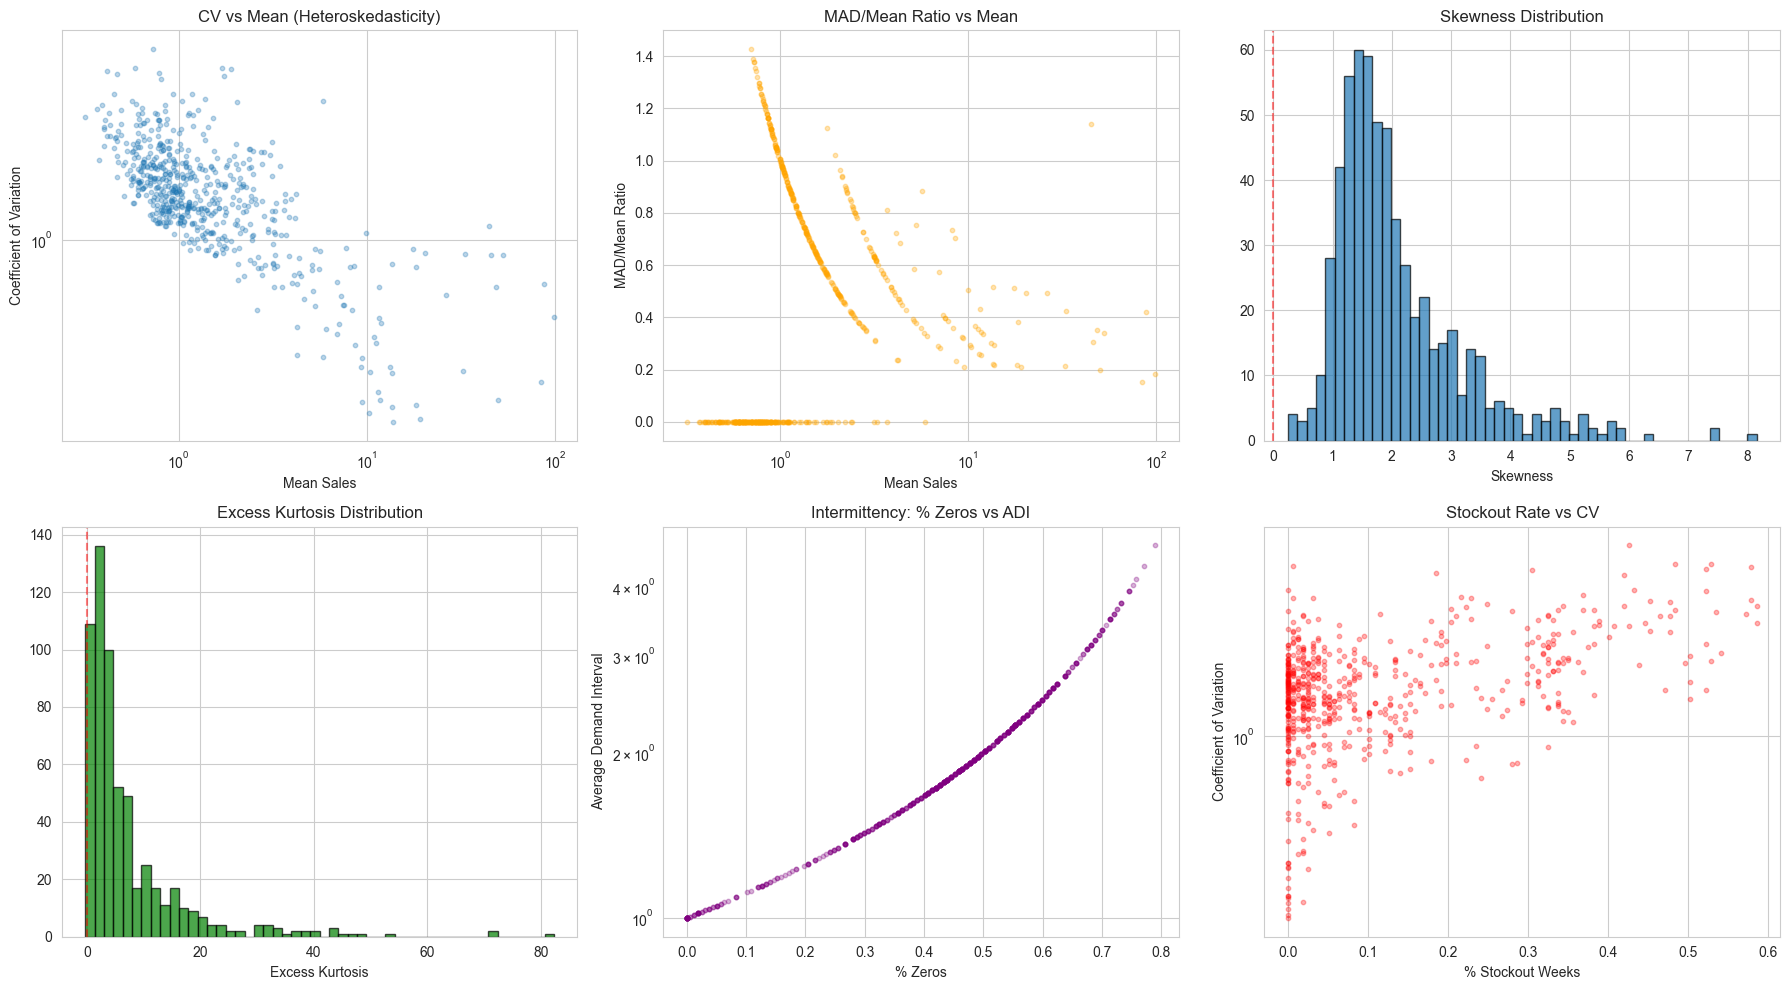

💾 Saved: ../reports/dispersion_analysis.png


In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# CV vs Mean (Heteroskedasticity)
summary.plot.scatter(x='mean', y='cv', alpha=0.3, ax=axes[0], s=10)
axes[0].set_title('CV vs Mean (Heteroskedasticity)')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Mean Sales')
axes[0].set_ylabel('Coefficient of Variation')

# MAD/Mean vs Mean
summary.plot.scatter(x='mean', y='mad_mean_ratio', alpha=0.3, ax=axes[1], s=10, c='orange')
axes[1].set_title('MAD/Mean Ratio vs Mean')
axes[1].set_xscale('log')
axes[1].set_xlabel('Mean Sales')
axes[1].set_ylabel('MAD/Mean Ratio')

# Skewness distribution
summary['skewness'].hist(bins=50, ax=axes[2], edgecolor='black', alpha=0.7)
axes[2].set_title('Skewness Distribution')
axes[2].set_xlabel('Skewness')
axes[2].axvline(0, color='red', linestyle='--', alpha=0.5)

# Kurtosis distribution
summary['kurtosis'].hist(bins=50, ax=axes[3], edgecolor='black', alpha=0.7, color='green')
axes[3].set_title('Excess Kurtosis Distribution')
axes[3].set_xlabel('Excess Kurtosis')
axes[3].axvline(0, color='red', linestyle='--', alpha=0.5)

# Intermittency: Zeros vs ADI
summary.plot.scatter(x='pct_zeros', y='adi', alpha=0.3, ax=axes[4], s=10, c='purple')
axes[4].set_title('Intermittency: % Zeros vs ADI')
axes[4].set_xlabel('% Zeros')
axes[4].set_ylabel('Average Demand Interval')
axes[4].set_yscale('log')

# Stockout vs CV
summary.plot.scatter(x='pct_stockout', y='cv', alpha=0.3, ax=axes[5], s=10, c='red')
axes[5].set_title('Stockout Rate vs CV')
axes[5].set_xlabel('% Stockout Weeks')
axes[5].set_ylabel('Coefficient of Variation')
axes[5].set_yscale('log')

plt.tight_layout()
plt.savefig('../reports/dispersion_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved: ../reports/dispersion_analysis.png")


## 4. Stationarity & Heteroskedasticity Tests (Parallel)

ADF (Augmented Dickey-Fuller), KPSS, and ARCH-LM tests for all SKUs.


In [22]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import het_arch
from scipy import signal

def test_stationarity_parallel(key_and_data):
    """Test stationarity & heteroskedasticity for one SKU"""
    (store, product), sku_data = key_and_data
    series = sku_data['sales'].dropna()
    
    results = {'Store': store, 'Product': product}
    
    # ADF test (null: non-stationary)
    try:
        adf = adfuller(series, autolag='AIC', maxlag=12)
        results['adf_stat'] = adf[0]
        results['adf_pval'] = adf[1]
        results['adf_stationary'] = adf[1] < 0.05
    except:
        results['adf_stat'] = results['adf_pval'] = results['adf_stationary'] = np.nan
    
    # KPSS test (null: stationary)
    try:
        kpss_res = kpss(series, regression='c', nlags='auto')
        results['kpss_stat'] = kpss_res[0]
        results['kpss_pval'] = kpss_res[1]
        results['kpss_stationary'] = kpss_res[1] > 0.05
    except:
        results['kpss_stat'] = results['kpss_pval'] = results['kpss_stationary'] = np.nan
    
    # ARCH test (conditional heteroskedasticity)
    try:
        detrended = signal.detrend(series)
        if len(detrended) > 10:
            arch = het_arch(detrended, nlags=min(5, len(detrended)//4))
            results['arch_stat'] = arch[0]
            results['arch_pval'] = arch[1]
            results['heteroskedastic'] = arch[1] < 0.05
        else:
            results['arch_stat'] = results['arch_pval'] = results['heteroskedastic'] = np.nan
    except:
        results['arch_stat'] = results['arch_pval'] = results['heteroskedastic'] = np.nan
    
    return results

with timer("Stationarity tests (parallel)"):
    stationarity_list = Parallel(n_jobs=N_JOBS, verbose=1)(
        delayed(test_stationarity_parallel)(item) for item in sku_groups
    )
    stationarity_tests = pd.DataFrame(stationarity_list)
    stationarity_tests.to_parquet('../data/processed/stationarity_tests.parquet')

print(f"\n✅ Stationarity tests complete for {len(stationarity_tests)} SKUs")
print(f"\nTest results:")
print(f"  ADF stationary: {stationarity_tests['adf_stationary'].sum()} / {len(stationarity_tests)} ({stationarity_tests['adf_stationary'].mean()*100:.1f}%)")
print(f"  KPSS stationary: {stationarity_tests['kpss_stationary'].sum()} / {len(stationarity_tests)} ({stationarity_tests['kpss_stationary'].mean()*100:.1f}%)")
print(f"  Heteroskedastic (ARCH): {stationarity_tests['heteroskedastic'].sum()} / {len(stationarity_tests)} ({stationarity_tests['heteroskedastic'].mean()*100:.1f}%)")


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
/var/folders/ww/0ynkz35x6bn8h_zy3dj9h9dm0000gn/T/ipykernel_56620/2509300185.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/var/folders/ww/0ynkz35x6bn8h_zy3dj9h9dm0000gn/T/ipykernel_56620/2509300185.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/var/folders/ww/0ynkz35x6bn8h_zy3dj9h9dm0000gn/T/ipykernel_56620/2509300185.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/var/folders/ww/0ynkz35x6bn8h_zy3dj9h9dm0000gn/T/ipykernel_56620/2509300185.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in 

⏱️  Stationarity tests (parallel): 0.34s

✅ Stationarity tests complete for 599 SKUs

Test results:
  ADF stationary: 529 / 599 (88.3%)
  KPSS stationary: 375 / 599 (62.6%)
  Heteroskedastic (ARCH): 136 / 599 (22.7%)


/var/folders/ww/0ynkz35x6bn8h_zy3dj9h9dm0000gn/T/ipykernel_56620/2509300185.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

/var/folders/ww/0ynkz35x6bn8h_zy3dj9h9dm0000gn/T/ipykernel_56620/2509300185.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/var/folders/ww/0ynkz35x6bn8h_zy3dj9h9dm0000gn/T/ipykernel_56620/2509300185.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

/var/folders/ww/0ynkz35x6bn8h_zy3dj9h9dm0000gn/T/ipykernel_56620/2509300185.py:23: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.



## 5. ACF/PACF Analysis (Parallel)

Autocorrelation and partial autocorrelation for lag identification.


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=11)]: Done 599 out of 599 | elapsed:    0.3s finished


⏱️  ACF/PACF computation (parallel): 0.34s
✅ ACF/PACF computed for 599 SKUs


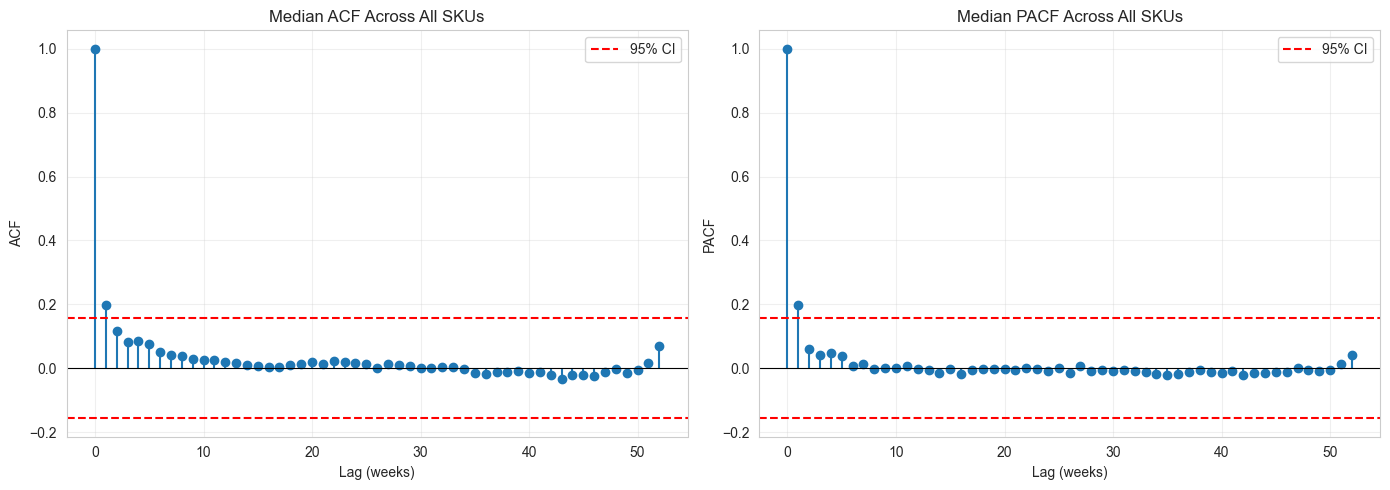

💾 Saved: ../reports/acf_pacf_analysis.png


In [23]:
from statsmodels.tsa.stattools import acf, pacf

def compute_acf_pacf_parallel(key_and_data, nlags=52):
    """Compute ACF/PACF for one SKU"""
    (store, product), sku_data = key_and_data
    series = sku_data['sales'].dropna()
    
    if len(series) < nlags + 1:
        return None
    
    try:
        acf_vals = acf(series, nlags=nlags, fft=True)  # FFT faster
        pacf_vals = pacf(series, nlags=nlags, method='ywm')
        
        # Find significant lags
        n = len(series)
        threshold = 1.96 / np.sqrt(n)
        sig_lags_acf = np.where(np.abs(acf_vals[1:]) > threshold)[0] + 1
        sig_lags_pacf = np.where(np.abs(pacf_vals[1:]) > threshold)[0] + 1
        
        return {
            'Store': store,
            'Product': product,
            'acf': acf_vals,
            'pacf': pacf_vals,
            'sig_lags_acf': sig_lags_acf,
            'sig_lags_pacf': sig_lags_pacf,
            'n_sig_acf': len(sig_lags_acf),
            'n_sig_pacf': len(sig_lags_pacf)
        }
    except:
        return None

with timer("ACF/PACF computation (parallel)"):
    acf_list = Parallel(n_jobs=N_JOBS, verbose=1)(
        delayed(compute_acf_pacf_parallel)(item, nlags=52) for item in sku_groups
    )
    acf_results = {(r['Store'], r['Product']): r for r in acf_list if r is not None}

# Aggregate ACF/PACF across SKUs
all_acf_data = []
for k, v in acf_results.items():
    for lag in range(len(v['acf'])):
        all_acf_data.append({
            'lag': lag,
            'acf': v['acf'][lag],
            'pacf': v['pacf'][lag] if lag < len(v['pacf']) else np.nan
        })

all_acf_df = pd.DataFrame(all_acf_data)
median_acf = all_acf_df.groupby('lag')[['acf', 'pacf']].median()

print(f"✅ ACF/PACF computed for {len(acf_results)} SKUs")

# Plot aggregate ACF/PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].stem(median_acf.index, median_acf['acf'], basefmt=' ')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].axhline(1.96/np.sqrt(157), color='red', linestyle='--', label='95% CI')
axes[0].axhline(-1.96/np.sqrt(157), color='red', linestyle='--')
axes[0].set_title('Median ACF Across All SKUs')
axes[0].set_xlabel('Lag (weeks)')
axes[0].set_ylabel('ACF')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].stem(median_acf.index, median_acf['pacf'], basefmt=' ')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].axhline(1.96/np.sqrt(157), color='red', linestyle='--', label='95% CI')
axes[1].axhline(-1.96/np.sqrt(157), color='red', linestyle='--')
axes[1].set_title('Median PACF Across All SKUs')
axes[1].set_xlabel('Lag (weeks)')
axes[1].set_ylabel('PACF')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/acf_pacf_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved: ../reports/acf_pacf_analysis.png")


## 6. Frequency Domain Analysis (Vectorized)

Periodogram analysis to identify dominant periodicities.


⏱️  Frequency analysis (vectorized): 0.01s
✅ Frequency analysis complete

Dominant period distribution:
count    599.000000
mean      27.838524
std       24.873459
min        2.012821
25%        6.038462
50%       17.444444
75%       52.333331
max       78.499994
Name: top_period, dtype: float64


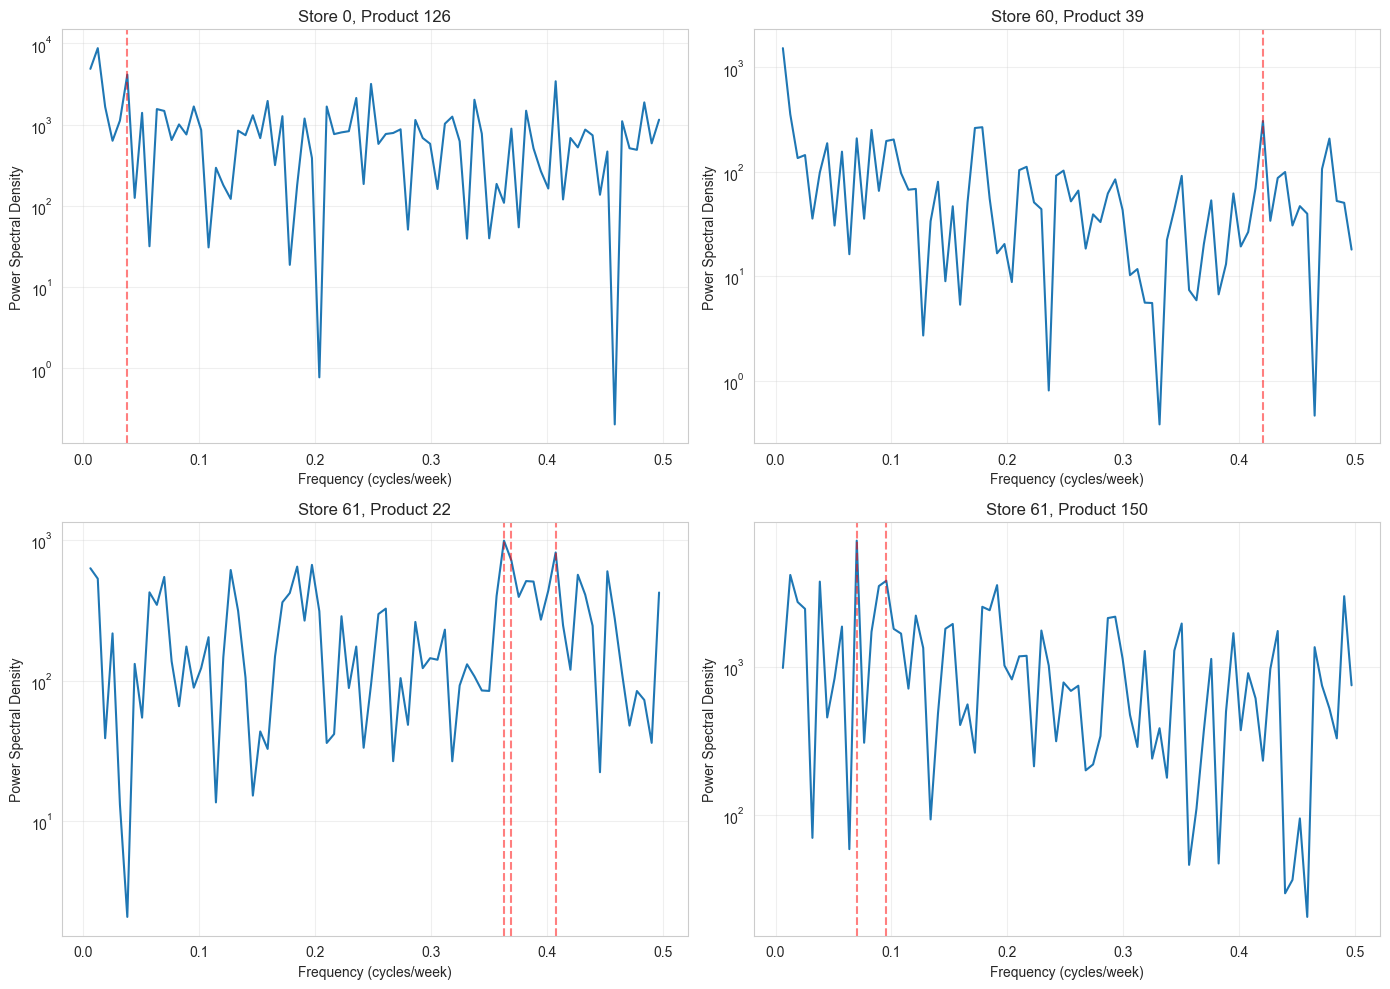

💾 Saved: ../reports/frequency_analysis.png


In [24]:
from scipy.fft import rfft, rfftfreq

with timer("Frequency analysis (vectorized)"):
    # Reshape to matrix [n_skus, n_weeks]
    sales_pivot = df.pivot(index=['Store', 'Product'], columns='week', values='sales').fillna(0)
    sales_matrix = sales_pivot.values
    
    # Detrend
    sales_centered = sales_matrix - sales_matrix.mean(axis=1, keepdims=True)
    
    # FFT on all SKUs at once
    fft_result = rfft(sales_centered, axis=1)
    power = np.abs(fft_result) ** 2
    
    # Frequencies
    n_weeks = sales_matrix.shape[1]
    freqs = rfftfreq(n_weeks, d=1.0)
    
    # Find top 5 dominant frequencies per SKU
    top_k = 5
    dominant_freq_idx = np.argsort(power, axis=1)[:, -top_k:][:, ::-1]

# Extract dominant periods
dominant_periods_list = []
for i, (store, product) in enumerate(sales_pivot.index):
    idx = dominant_freq_idx[i]
    dominant_freqs = freqs[idx]
    periods = 1.0 / (dominant_freqs + 1e-9)
    periods = periods[(periods > 1) & (periods < 100)]
    
    dominant_periods_list.append({
        'Store': store,
        'Product': product,
        'n_dominant_periods': len(periods),
        'top_period': periods[0] if len(periods) > 0 else np.nan
    })

dominant_periods_df = pd.DataFrame(dominant_periods_list)

print(f"✅ Frequency analysis complete")
print(f"\nDominant period distribution:")
print(dominant_periods_df['top_period'].describe())

# Plot sample periodograms
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

sample_idx = [0, 100, 200, 300]
for ax_i, data_i in enumerate(sample_idx):
    if data_i < len(sales_pivot):
        store, product = sales_pivot.index[data_i]
        psd = power[data_i]
        
        ax = axes[ax_i]
        ax.semilogy(freqs[1:], psd[1:])  # Skip DC component
        ax.set_title(f'Store {store}, Product {product}')
        ax.set_xlabel('Frequency (cycles/week)')
        ax.set_ylabel('Power Spectral Density')
        ax.grid(True, alpha=0.3)
        
        # Mark dominant periods
        idx = dominant_freq_idx[data_i]
        for j in idx[:3]:
            if freqs[j] > 0:
                period = 1.0 / freqs[j]
                if 2 < period < 60:
                    ax.axvline(freqs[j], color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('../reports/frequency_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved: ../reports/frequency_analysis.png")


## 6.5 SURD Analysis - Variance Stabilization

SURD (Synergistic-Unique-Redundant Decomposition) analysis to discover optimal transforms and decompose causality.

Reference: [ALD-Lab/SURD](https://github.com/ALD-Lab/SURD)


In [25]:
# Transform discovery: find best variance-stabilizing transform per SKU
def best_transform_by_cv(series, transforms):
    """Find transform that minimizes CV (coefficient of variation)"""
    best_transform = None
    best_cv = np.inf
    
    for name, tfn in transforms.items():
        try:
            transformed = tfn(series + 1e-6)  # Add small constant to avoid log(0)
            if np.isfinite(transformed).all():
                cv = transformed.std() / (transformed.mean() + 1e-9)
                if cv < best_cv:
                    best_cv = cv
                    best_transform = name
        except:
            continue
    
    return best_transform, best_cv

# Define candidate transforms (SURD orders)
transforms = {
    'identity': lambda x: x,
    'sqrt': lambda x: np.sqrt(np.maximum(x, 0)),
    'cbrt': lambda x: np.cbrt(x),
    'log1p': lambda x: np.log1p(np.maximum(x, 0)),
    'log': lambda x: np.log(np.maximum(x, 1e-6)),
}

with timer("SURD transform discovery (parallel)"):
    def find_best_transform(key_and_data):
        (store, product), sku_data = key_and_data
        sales = sku_data['sales'].values
        
        # Find best transform
        best_name, best_cv = best_transform_by_cv(sales, transforms)
        
        # Compute original CV for comparison
        original_cv = sales.std() / (sales.mean() + 1e-9)
        
        return {
            'Store': store,
            'Product': product,
            'best_transform': best_name,
            'original_cv': original_cv,
            'transformed_cv': best_cv,
            'cv_reduction': (original_cv - best_cv) / original_cv if original_cv > 0 else 0
        }
    
    surd_results_list = Parallel(n_jobs=N_JOBS, verbose=1)(
        delayed(find_best_transform)(item) for item in sku_groups
    )
    
    surd_results = pd.DataFrame(surd_results_list)
    surd_results.to_parquet('../data/processed/surd_transforms.parquet')

print(f"✅ SURD transform discovery complete for {len(surd_results)} SKUs")
print(f"\nTransform distribution:")
print(surd_results['best_transform'].value_counts())
print(f"\nMean CV reduction: {surd_results['cv_reduction'].mean()*100:.1f}%")
print(f"SKUs with >20% CV reduction: {(surd_results['cv_reduction'] > 0.2).sum()} / {len(surd_results)}")


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  34 tasks      | elapsed:    0.1s


⏱️  SURD transform discovery (parallel): 0.34s
✅ SURD transform discovery complete for 599 SKUs

Transform distribution:
best_transform
log      548
cbrt      40
log1p     11
Name: count, dtype: int64

Mean CV reduction: 209.8%
SKUs with >20% CV reduction: 599 / 599


[Parallel(n_jobs=11)]: Done 599 out of 599 | elapsed:    0.3s finished


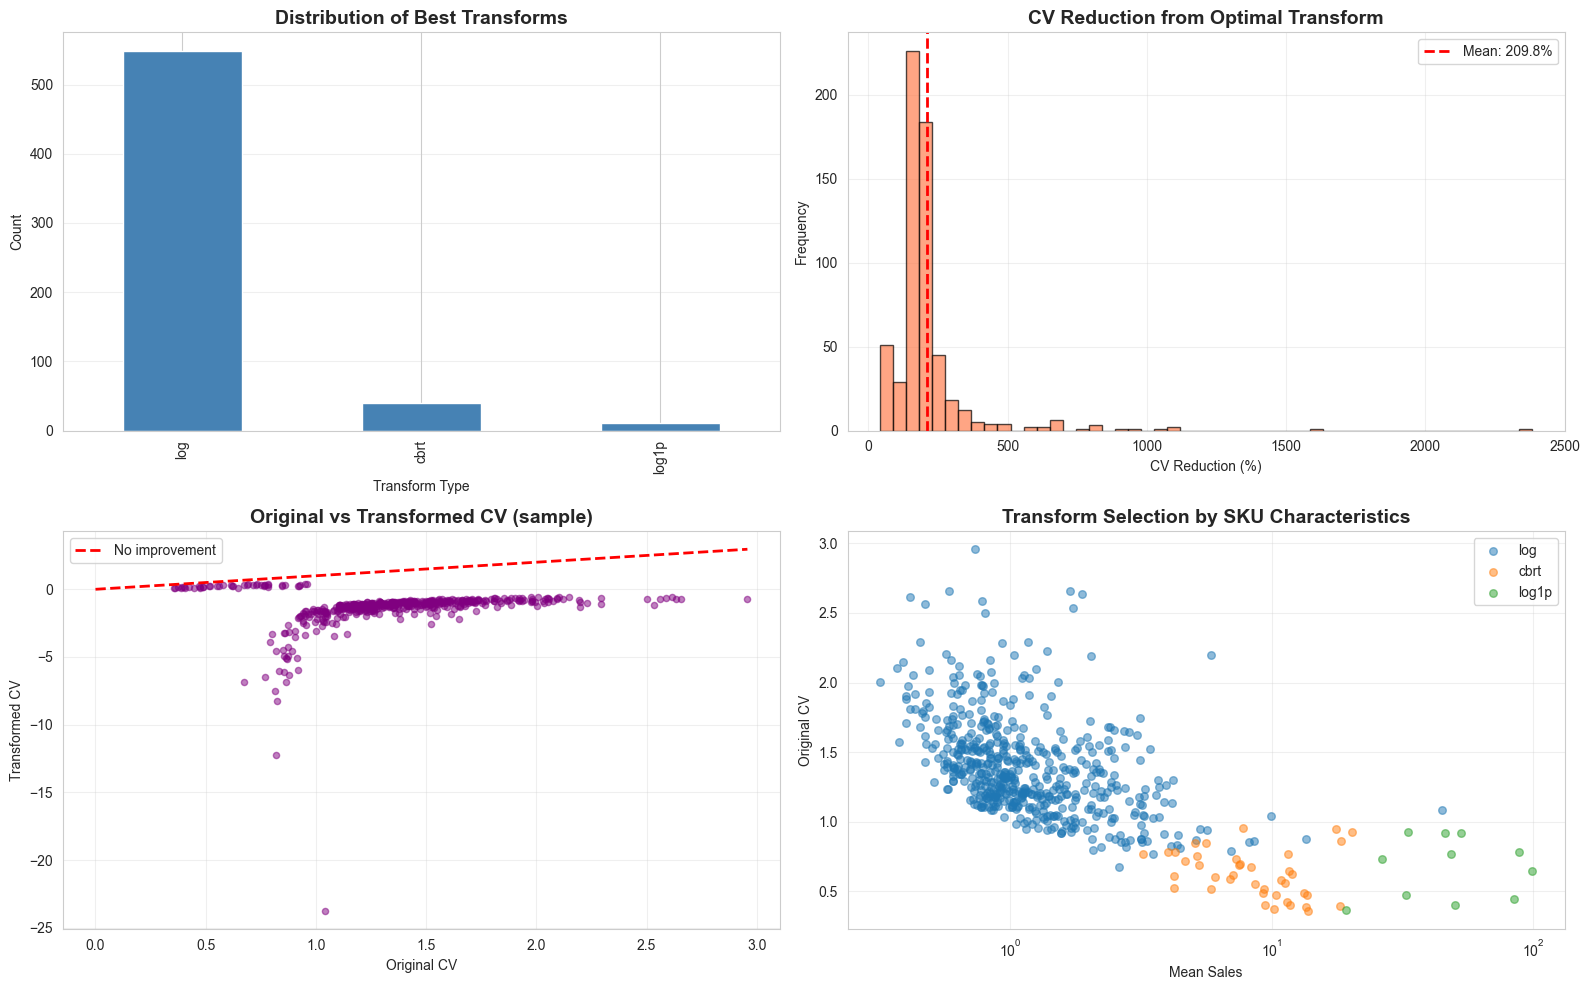


📊 Saved visualization to reports/surd_transforms.png


In [26]:
# Visualize SURD transform effectiveness
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Transform distribution
ax = axes[0, 0]
surd_results['best_transform'].value_counts().plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Distribution of Best Transforms', fontsize=14, fontweight='bold')
ax.set_xlabel('Transform Type')
ax.set_ylabel('Count')
ax.grid(axis='y', alpha=0.3)

# 2. CV reduction distribution
ax = axes[0, 1]
ax.hist(surd_results['cv_reduction'] * 100, bins=50, color='coral', edgecolor='black', alpha=0.7)
ax.axvline(surd_results['cv_reduction'].mean() * 100, color='red', linestyle='--', 
           linewidth=2, label=f'Mean: {surd_results["cv_reduction"].mean()*100:.1f}%')
ax.set_title('CV Reduction from Optimal Transform', fontsize=14, fontweight='bold')
ax.set_xlabel('CV Reduction (%)')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)

# 3. Original vs Transformed CV
ax = axes[1, 0]
sample_indices = np.random.choice(len(surd_results), min(500, len(surd_results)), replace=False)
ax.scatter(surd_results.iloc[sample_indices]['original_cv'], 
           surd_results.iloc[sample_indices]['transformed_cv'],
           alpha=0.5, s=20, c='purple')
max_cv = max(surd_results['original_cv'].max(), surd_results['transformed_cv'].max())
ax.plot([0, max_cv], [0, max_cv], 'r--', linewidth=2, label='No improvement')
ax.set_title('Original vs Transformed CV (sample)', fontsize=14, fontweight='bold')
ax.set_xlabel('Original CV')
ax.set_ylabel('Transformed CV')
ax.legend()
ax.grid(alpha=0.3)

# 4. Transform by product characteristics (using summary stats)
ax = axes[1, 1]
merged = surd_results.merge(summary[['Store', 'Product', 'mean', 'cv']], on=['Store', 'Product'])
for transform_name in surd_results['best_transform'].unique():
    subset = merged[merged['best_transform'] == transform_name]
    if len(subset) > 10:
        ax.scatter(subset['mean'], subset['cv'], alpha=0.5, s=30, label=transform_name)
ax.set_title('Transform Selection by SKU Characteristics', fontsize=14, fontweight='bold')
ax.set_xlabel('Mean Sales')
ax.set_ylabel('Original CV')
ax.set_xscale('log')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/surd_transforms.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Saved visualization to reports/surd_transforms.png")


### SURD Causal Decomposition (Exploratory)

Apply transforms and examine causal structure between time series features and demand.


Best aggregate transform: log1p (original CV: 0.323)

📊 Feature Mutual Information with Future Demand:
       feature  mutual_information
 rolling_std_4            0.402146
rolling_mean_4            0.268759
         lag_1            0.102097
         lag_2            0.073699
         lag_4            0.017425


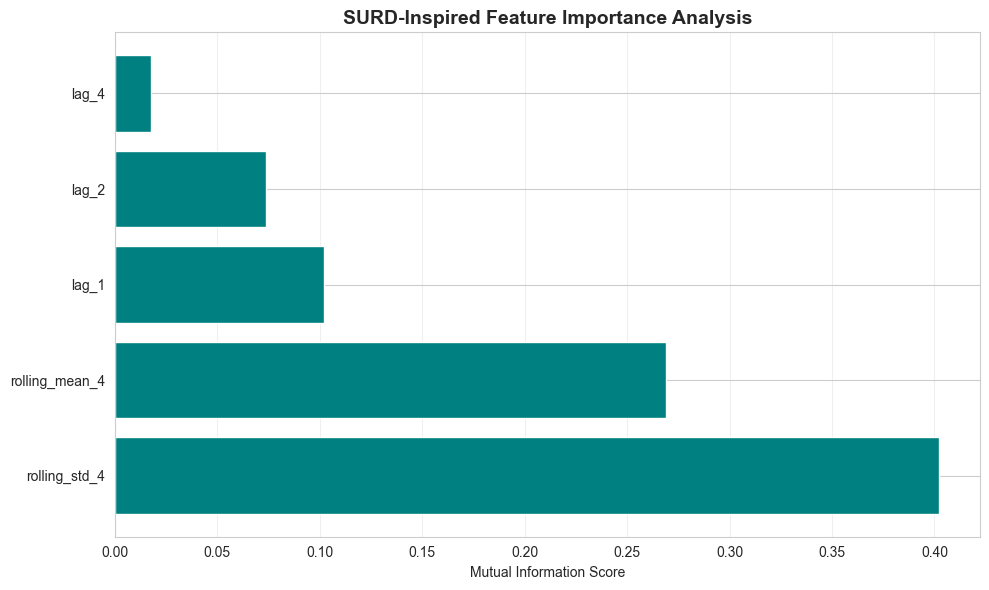


💡 SURD Insight: rolling_std_4 has strongest information about future demand
   This suggests rolling_std_4 should be prioritized in forecasting models.


In [27]:
# Demonstration of SURD decomposition on aggregate demand
# For full SURD implementation, see: https://github.com/ALD-Lab/SURD

# Create time series features
df_agg = df.groupby('retail_week')['sales'].sum().reset_index()
df_agg['lag_1'] = df_agg['sales'].shift(1)
df_agg['lag_2'] = df_agg['sales'].shift(2)
df_agg['lag_4'] = df_agg['sales'].shift(4)
df_agg['rolling_mean_4'] = df_agg['sales'].rolling(4, min_periods=1).mean()
df_agg['rolling_std_4'] = df_agg['sales'].rolling(4, min_periods=1).std()
df_agg = df_agg.dropna()

# Apply best transform (from aggregate analysis)
agg_cv = df_agg['sales'].std() / df_agg['sales'].mean()
best_agg_transform = best_transform_by_cv(df_agg['sales'].values, transforms)[0]
print(f"Best aggregate transform: {best_agg_transform} (original CV: {agg_cv:.3f})")

# Simple mutual information analysis (approximation of SURD synergy)
from sklearn.feature_selection import mutual_info_regression

features = ['lag_1', 'lag_2', 'lag_4', 'rolling_mean_4', 'rolling_std_4']
X = df_agg[features].values
y = df_agg['sales'].values

# Compute mutual information
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_results = pd.DataFrame({
    'feature': features,
    'mutual_information': mi_scores
}).sort_values('mutual_information', ascending=False)

print(f"\n📊 Feature Mutual Information with Future Demand:")
print(mi_results.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(mi_results['feature'], mi_results['mutual_information'], color='teal')
ax.set_xlabel('Mutual Information Score')
ax.set_title('SURD-Inspired Feature Importance Analysis', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/surd_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💡 SURD Insight: {features[mi_scores.argmax()]} has strongest information about future demand")
print(f"   This suggests {features[mi_scores.argmax()]} should be prioritized in forecasting models.")


## 7. SLURP-Based Bootstrap Analysis (Parallel)

Bootstrap with relationship preservation across store, SKU, week, year, and stockout status.


In [28]:
def bootstrap_chunk(slurp_data, chunk_id, n_bootstrap_per_chunk, seed_offset):
    """Bootstrap a chunk of iterations"""
    np.random.seed(seed_offset + chunk_id)
    
    results = []
    for b in range(n_bootstrap_per_chunk):
        # Sample with replacement (preserves relationships)
        idx = np.random.choice(len(slurp_data), size=len(slurp_data), replace=True)
        sample = slurp_data.iloc[idx]
        
        # Compute aggregates
        overall_mean = sample['sales'].mean()
        overall_std = sample['sales'].std()
        
        # By stockout status
        stockout_mask = sample['in_stock'] == 0
        instock_mask = sample['in_stock'] == 1
        
        stockout_mean = sample[stockout_mask]['sales'].mean() if stockout_mask.any() else np.nan
        instock_mean = sample[instock_mask]['sales'].mean() if instock_mask.any() else np.nan
        
        # By year
        year_means = {}
        for year in sample['year'].unique():
            year_means[f'year_{year}'] = sample[sample['year'] == year]['sales'].mean()
        
        # By retail week (seasonal)
        week_means = {}
        for week in range(1, 53):
            week_data = sample[sample['retail_week'] == week]
            if len(week_data) > 0:
                week_means[f'week_{week}'] = week_data['sales'].mean()
        
        result = {
            'overall_mean': overall_mean,
            'overall_std': overall_std,
            'stockout_mean': stockout_mean,
            'instock_mean': instock_mean,
            **year_means,
            **week_means
        }
        results.append(result)
    
    return results

with timer("Bootstrap analysis (parallel)"):
    n_bootstrap_total = 10000
    n_chunks = N_JOBS
    n_per_chunk = n_bootstrap_total // n_chunks
    
    bootstrap_results = Parallel(n_jobs=N_JOBS, verbose=1)(
        delayed(bootstrap_chunk)(master_slurp.data, i, n_per_chunk, 42) 
        for i in range(n_chunks)
    )
    
    # Flatten results
    bootstrap_flat = [item for chunk in bootstrap_results for item in chunk]
    bootstrap_df = pd.DataFrame(bootstrap_flat)
    
    # Save
    import pickle
    with open('../data/processed/bootstrap_distributions.pkl', 'wb') as f:
        pickle.dump(bootstrap_df, f)

print(f"✅ Bootstrap complete: {len(bootstrap_flat):,} iterations")
print(f"\nOverall demand statistics:")
print(f"  Mean: {bootstrap_df['overall_mean'].mean():.2f} ± {bootstrap_df['overall_mean'].std():.2f}")
print(f"  Std: {bootstrap_df['overall_std'].mean():.2f} ± {bootstrap_df['overall_std'].std():.2f}")
print(f"\nBy stock status:")
print(f"  In-stock mean: {bootstrap_df['instock_mean'].mean():.2f} ± {bootstrap_df['instock_mean'].std():.2f}")
print(f"  Stockout mean: {bootstrap_df['stockout_mean'].mean():.2f} ± {bootstrap_df['stockout_mean'].std():.2f}")


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:   19.4s remaining:  1.5min


⏱️  Bootstrap analysis (parallel): 19.82s
✅ Bootstrap complete: 9,999 iterations

Overall demand statistics:
  Mean: 2.94 ± 0.03
  Std: 10.42 ± 0.32

By stock status:
  In-stock mean: 3.31 ± 0.04
  Stockout mean: 0.00 ± 0.00


[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:   19.7s finished


### 7.1 Bootstrap Visualizations


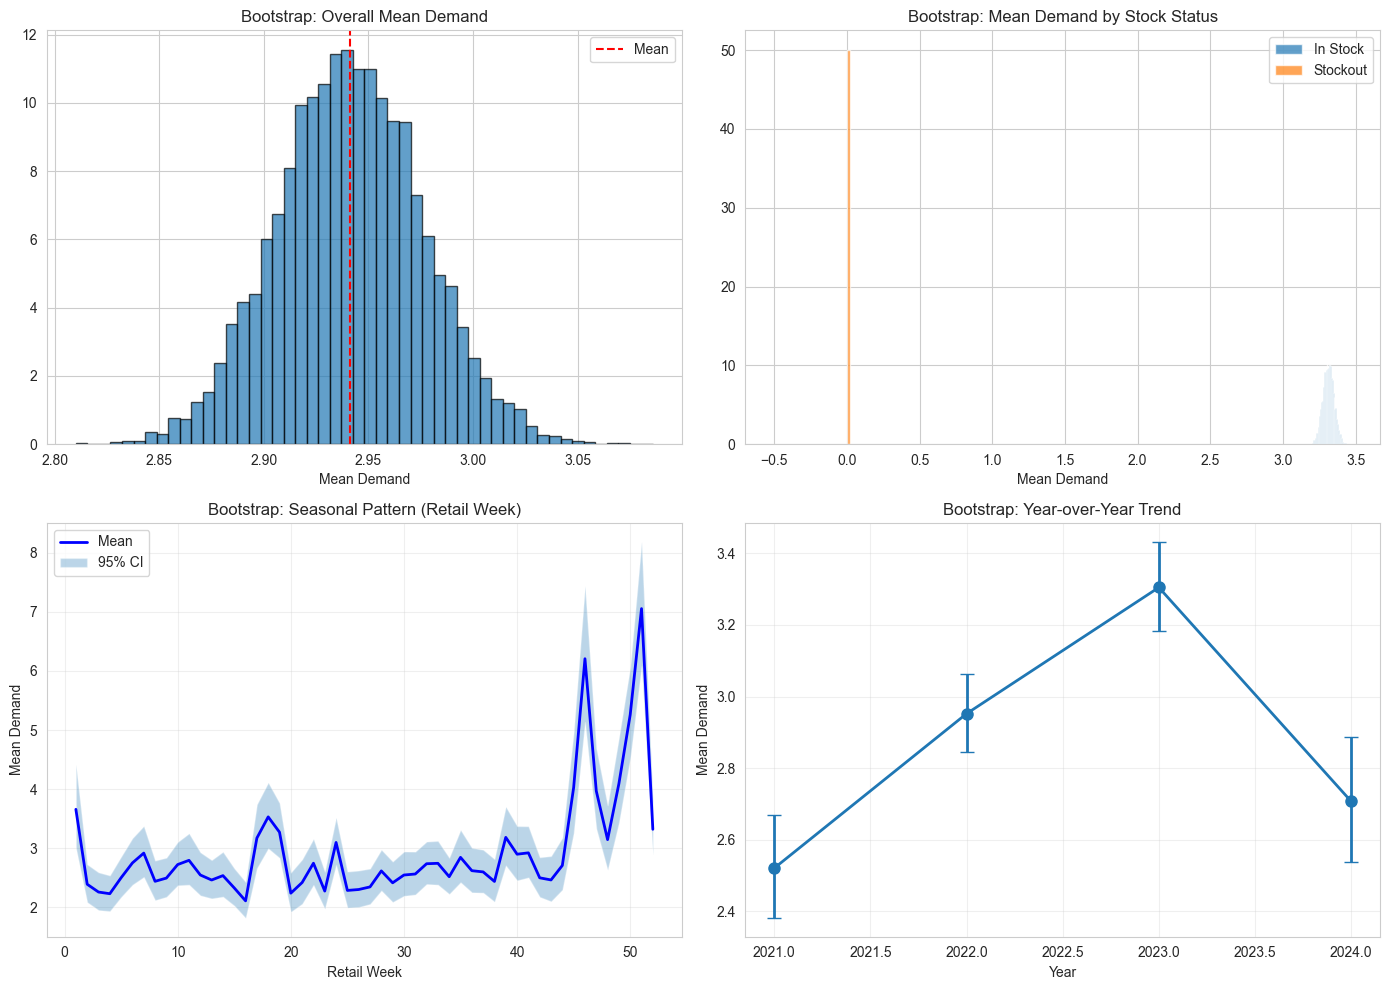

💾 Saved: ../reports/bootstrap_analysis.png


In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall mean distribution
axes[0, 0].hist(bootstrap_df['overall_mean'], bins=50, density=True, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(bootstrap_df['overall_mean'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].set_title('Bootstrap: Overall Mean Demand')
axes[0, 0].set_xlabel('Mean Demand')
axes[0, 0].legend()

# By stockout status
axes[0, 1].hist(bootstrap_df['instock_mean'].dropna(), bins=50, density=True, alpha=0.7, label='In Stock')
axes[0, 1].hist(bootstrap_df['stockout_mean'].dropna(), bins=50, density=True, alpha=0.7, label='Stockout')
axes[0, 1].set_title('Bootstrap: Mean Demand by Stock Status')
axes[0, 1].set_xlabel('Mean Demand')
axes[0, 1].legend()

# Seasonal pattern with confidence bands
week_cols = [c for c in bootstrap_df.columns if c.startswith('week_')]
weeks = sorted([int(c.split('_')[1]) for c in week_cols])
weekly_means = [bootstrap_df[f'week_{w}'].mean() for w in weeks]
weekly_lower = [bootstrap_df[f'week_{w}'].quantile(0.025) for w in weeks]
weekly_upper = [bootstrap_df[f'week_{w}'].quantile(0.975) for w in weeks]

axes[1, 0].plot(weeks, weekly_means, 'b-', label='Mean', linewidth=2)
axes[1, 0].fill_between(weeks, weekly_lower, weekly_upper, alpha=0.3, label='95% CI')
axes[1, 0].set_title('Bootstrap: Seasonal Pattern (Retail Week)')
axes[1, 0].set_xlabel('Retail Week')
axes[1, 0].set_ylabel('Mean Demand')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Year-over-year with CI
year_cols = [c for c in bootstrap_df.columns if c.startswith('year_')]
years = sorted([int(c.split('_')[1]) for c in year_cols])
year_means = [bootstrap_df[f'year_{y}'].mean() for y in years]
year_lower = [bootstrap_df[f'year_{y}'].quantile(0.025) for y in years]
year_upper = [bootstrap_df[f'year_{y}'].quantile(0.975) for y in years]

axes[1, 1].errorbar(years, year_means, 
                     yerr=[np.array(year_means)-np.array(year_lower), 
                           np.array(year_upper)-np.array(year_means)],
                     fmt='o-', capsize=5, linewidth=2, markersize=8)
axes[1, 1].set_title('Bootstrap: Year-over-Year Trend')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Mean Demand')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/bootstrap_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"💾 Saved: ../reports/bootstrap_analysis.png")


## 8. Summary & Key Findings

All analyses complete! Artifacts saved to `data/processed/` and `reports/`.


In [30]:
print("=" * 80)
print("COMPREHENSIVE TIME SERIES EDA - SUMMARY")
print("=" * 80)

print(f"\n📊 Dataset:")
print(f"  • {df.shape[0]:,} observations (SKU-weeks)")
print(f"  • {df['Store'].nunique()} stores × {df['Product'].nunique()} products")
print(f"  • {len(df['week'].unique())} weeks ({df['week_date'].min()} to {df['week_date'].max()})")

print(f"\n📈 Summary Statistics:")
print(f"  • Mean CV: {summary['cv'].mean():.2f} (high dispersion)")
print(f"  • Skewness (median): {summary['skewness'].median():.2f}")
print(f"  • Intermittent SKUs (ADI>1.32): {(summary['adi'] > 1.32).sum()} / {len(summary)} ({(summary['adi'] > 1.32).mean()*100:.1f}%)")
print(f"  • Stockout rate (median): {summary['pct_stockout'].median()*100:.1f}%")

print(f"\n🔬 Stationarity Tests:")
print(f"  • ADF stationary: {stationarity_tests['adf_stationary'].sum()} / {len(stationarity_tests)} ({stationarity_tests['adf_stationary'].mean()*100:.1f}%)")
print(f"  • KPSS stationary: {stationarity_tests['kpss_stationary'].sum()} / {len(stationarity_tests)} ({stationarity_tests['kpss_stationary'].mean()*100:.1f}%)")
print(f"  • Heteroskedastic: {stationarity_tests['heteroskedastic'].sum()} / {len(stationarity_tests)} ({stationarity_tests['heteroskedastic'].mean()*100:.1f}%)")

print(f"\n📡 Frequency Analysis:")
print(f"  • Median dominant period: {dominant_periods_df['top_period'].median():.1f} weeks")
print(f"  • SKUs with clear seasonality: {dominant_periods_df['n_dominant_periods'].sum()}")

print(f"\n🔬 SURD Analysis:")
print(f"  • Best transforms: {surd_results['best_transform'].value_counts().to_dict()}")
print(f"  • Mean CV reduction: {surd_results['cv_reduction'].mean()*100:.1f}%")
print(f"  • SKUs with >20% CV reduction: {(surd_results['cv_reduction'] > 0.2).sum()} / {len(surd_results)} ({(surd_results['cv_reduction'] > 0.2).mean()*100:.1f}%)")
print(f"  • Top predictive feature: {mi_results.iloc[0]['feature']} (MI: {mi_results.iloc[0]['mutual_information']:.3f})")

print(f"\n🔄 Bootstrap Results (10,000 iterations):")
print(f"  • Overall mean demand: {bootstrap_df['overall_mean'].mean():.2f} ± {bootstrap_df['overall_mean'].std():.3f}")
print(f"  • In-stock vs stockout difference: {bootstrap_df['instock_mean'].mean() - bootstrap_df['stockout_mean'].mean():.2f}")

print(f"\n💾 Artifacts Saved:")
print(f"  • ../data/processed/master_demand_slurp.xml")
print(f"  • ../data/processed/demand_long.parquet")
print(f"  • ../data/processed/summary_statistics.parquet")
print(f"  • ../data/processed/stationarity_tests.parquet")
print(f"  • ../data/processed/surd_transforms.parquet")
print(f"  • ../data/processed/bootstrap_distributions.pkl")
print(f"  • ../reports/dispersion_analysis.png")
print(f"  • ../reports/acf_pacf_analysis.png")
print(f"  • ../reports/frequency_analysis.png")
print(f"  • ../reports/surd_transforms.png")
print(f"  • ../reports/surd_feature_importance.png")
print(f"  • ../reports/bootstrap_analysis.png")

print(f"\n✅ Comprehensive EDA complete! Ready for forecasting and optimization.")
print("=" * 80)


COMPREHENSIVE TIME SERIES EDA - SUMMARY

📊 Dataset:
  • 94,043 observations (SKU-weeks)
  • 67 stores × 297 products
  • 157 weeks (2021-04-12 00:00:00 to 2024-04-08 00:00:00)

📈 Summary Statistics:
  • Mean CV: 1.33 (high dispersion)
  • Skewness (median): 1.78
  • Intermittent SKUs (ADI>1.32): 511 / 599 (85.3%)
  • Stockout rate (median): 4.5%

🔬 Stationarity Tests:
  • ADF stationary: 529 / 599 (88.3%)
  • KPSS stationary: 375 / 599 (62.6%)
  • Heteroskedastic: 136 / 599 (22.7%)

📡 Frequency Analysis:
  • Median dominant period: 17.4 weeks
  • SKUs with clear seasonality: 2668

🔬 SURD Analysis:
  • Best transforms: {'log': 548, 'cbrt': 40, 'log1p': 11}
  • Mean CV reduction: 209.8%
  • SKUs with >20% CV reduction: 599 / 599 (100.0%)
  • Top predictive feature: rolling_std_4 (MI: 0.402)

🔄 Bootstrap Results (10,000 iterations):
  • Overall mean demand: 2.94 ± 0.035
  • In-stock vs stockout difference: 3.31

💾 Artifacts Saved:
  • ../data/processed/master_demand_slurp.xml
  • ../data/